# AlBi 3
### Übungsblatt 11
*Markus Apel, Mathias Husted*

### Aufgabe 1: t-Test und Multiples Testen

Es sollen nun differentiell exprimierte Gene zwischen den Krebs- und gesunden Patienten
aus der Aufgabe der vorherigen Übung bestimmt werden.

a) Bevor Sie die differentiellen Gene suchen, müssen Sie die Daten normalisieren. Logarithmieren ($\log_{10}$) Sie zuerst die Expressionsdaten und normalisieren Sie diese mittels
der Quantil-Normalisierung. Sie können z.B. die normalize.quantiles() Funktion
aus der preprocessCore Library verwenden.

In [3]:
import pandas as pd
import numpy as np

data = pd.read_csv("expr_cel.txt", sep="\t")

data_log = data.copy()
data_log.iloc[:, 1:] = np.log2(data.iloc[:, 1:])

data_log.head()

,gene,K_18,K_19,G_20,K_21,K_22,K_23,G_24,G_25,G_26,G_27
0,1007_s_at,8.138528,7.989536,8.669771,8.586465,9.084277,8.142873,8.240314,8.559951,8.769838,8.656604
1,1053_at,6.799605,6.723149,7.549977,7.120497,7.796364,6.604368,7.206038,7.293702,7.608440,8.099348
2,117_at,7.246028,6.911692,7.551900,7.355792,8.043301,7.743151,7.886611,7.794741,7.930146,8.356012
3,121_at,8.642593,8.210671,9.170050,9.178042,9.392103,8.696098,8.958988,9.135196,9.341852,9.125155
4,1255_g_at,6.558421,6.210428,6.590961,6.902677,6.647458,6.320124,6.785289,6.636625,6.743488,7.432542


In [10]:
from sklearn.preprocessing import quantile_transform

data_normalized = data_log.copy()
data_normalized.iloc[:, 1:] = quantile_transform(
    data_log.iloc[:, 1:], 
    axis=0, 
    n_quantiles=data_log.shape[0],
    output_distribution='uniform',
    copy=True
)

data_normalized.head()

,gene,K_18,K_19,G_20,K_21,K_22,K_23,G_24,G_25,G_26,G_27
0,1007_s_at,0.887168,0.858714,0.866299,0.875185,0.892891,0.859409,0.797092,0.847942,0.867443,0.811633
1,1053_at,0.283695,0.411337,0.517975,0.249585,0.520376,0.174588,0.331493,0.388807,0.469840,0.457789
2,117_at,0.557403,0.519187,0.519097,0.370944,0.630560,0.762578,0.680490,0.629909,0.632647,0.656164
3,121_at,0.944168,0.889413,0.923792,0.941026,0.926036,0.929626,0.918181,0.923971,0.932364,0.916207
4,1255_g_at,0.160181,0.130133,0.101791,0.160989,0.063687,0.063058,0.131457,0.111440,0.072618,0.067636


b) Schreiben Sie ein Programm, welches als Input die gegebenen Daten erhält, die t-
Statistik und den zugehörigen p-Wert für jedes Gen berechnet. Sie können gleiche
Varianz in den beiden Gruppen annehmen und die degrees of freedom wie folgt
berechnen:
$$df = n_1 + n_2 − 2$$
wobei $n_i$ die Anzahl der Experimente in der jeweiligen Gruppe bezeichnet.

In [62]:
from scipy import stats

def perform_t_test(input_data_1, input_data_2):
    n_1 = len(input_data_1)
    n_2 = len(input_data_2)
    df = n_1 + n_2 - 2

    mean_1 = np.mean(input_data_1)
    mean_2 = np.mean(input_data_2)

    sum_1 = sum_2 = i = j = 0

    while i < n_1:
        sum_1 += (input_data_1[i] - mean_1) ** 2
        i += 1
    while j < n_2:
        sum_2 += (input_data_2[j] - mean_2) ** 2
        j += 1
    s = np.sqrt((1/df) * (sum_1 + sum_2))

    t = (mean_2 - mean_1) / (s * np.sqrt((1/(n_1) + (1/(n_2)))))

    p_value = 2 * (1 - stats.t.cdf(abs(t), df))

    return t, p_value


def test_all_genes(input_df):
    cancer_cols = [col for col in input_df.columns if col.startswith("K_")]
    healthy_cols = [col for col in input_df.columns if col.startswith("G_")]
    
    results = []
    for i, row in input_df.iterrows():
        gene_id = row.iloc[0]
        cancer_data = row[cancer_cols].values
        healthy_data = row[healthy_cols].values
        t, p = perform_t_test(cancer_data, healthy_data)
        results.append({'Gene': gene_id, 't_statistic': t, 'p_value': p})
        #print(f"Row {gene_id}: t = {t}, p = {p}")

    return pd.DataFrame(results)

c) Führen Sie Ihre Funktion auf den normalisierten Daten aus. Welches sind die Top-10
hochregulierten Gene in den Krebs- bzw. in den gesunden Patienten?

In [66]:
results_df = test_all_genes(data_normalized)
results_df.head()

,Gene,t_statistic,p_value
0,1007_s_at,-2.288954,0.051349
1,1053_at,1.511125,0.169203
2,117_at,0.791471,0.451495
3,121_at,-0.309978,0.764498
4,1255_g_at,-0.742182,0.479199


In [67]:
print("Top 10 hochregulierte Gene in Krebspatienten:")
top_cancer = results_df.nsmallest(10, 't_statistic')
print(top_cancer)

print("\n" + "="*50 + "\n")

print("Top 10 hochregulierte Gene in gesunden Parienten:")
top_healthy = results_df.nlargest(10, 't_statistic')
print(top_healthy)

Top 10 hochregulierte Gene in Krebspatienten:
              Gene  t_statistic       p_value
4378   204852_s_at   -20.810949  2.980317e-08
5331   205805_s_at   -16.216734  2.102071e-07
48     200028_s_at   -15.958610  2.381709e-07
4940   205414_s_at   -14.761972  4.361919e-07
3211     203685_at   -14.476487  5.073669e-07
7530   208022_s_at   -13.011092  1.154752e-06
2148     202621_at   -12.813677  1.298428e-06
20440  221078_s_at   -12.175234  1.919485e-06
1056   201529_s_at   -11.284446  3.420311e-06
10515  211072_x_at   -11.263095  3.469722e-06


Top 10 hochregulierte Gene in gesunden Parienten:
              Gene  t_statistic       p_value
18412    219049_at    52.469688  1.929368e-11
15880  216510_x_at    42.581510  1.019920e-10
9909   210432_s_at    41.406326  1.274694e-10
11944    212560_at    38.511810  2.270155e-10
5410     205884_at    22.006441  1.919552e-08
3499   203973_s_at    20.750396  3.049443e-08
2026   202499_s_at    20.112125  3.898788e-08
14152    214777_at    19.231

d) Wie viele signifikant differentiell exprimierte Gene finden Sie zum Signifikanzniveau
0.05? Begründen Sie kurz, warum die Anzahl der so gefundenen signifikanten Gene zu
hoch ist.

In [86]:
significant_rows = results_df[results_df["p_value"] < 0.05]
print(f"Signifikante Gene: {len(significant_rows)} von {len(results_df)}")
significant_rows.head()

Signifikante Gene: 3488 von 22282


,Gene,t_statistic,p_value
20,200000_s_at,-2.937156,1.879122e-02
29,200009_at,-3.068214,1.538955e-02
35,200015_s_at,-3.174699,1.310161e-02
45,200025_s_at,2.615580,3.086160e-02
48,200028_s_at,-15.958610,2.381709e-07


e) Führen Sie nun die Benjamini-Hochberg-Korrektur auf den p-Werten aus dem t-Test
durch. Implementieren Sie dazu eine Funktion, welche die Korrektur mit gegebenem
Parameter α berechnet und die Signifikanz der Einträge als SIGNIFIKANT/NICHT
SIGNIFIKANT ausgibt. Verwenden Sie den in der Vorlesung beschriebenen Algo-
rithmus und verwenden Sie keine implementierten Funktionen wie p.adjust oder
ähnliches.

f) Wie viele signifikanten Gene finden Sie nach der Korrektur?

In [88]:
def benjamini_hochberg(results_df, alpha):
    df = results_df.copy().sort_values('p_value').reset_index(drop=True)
    m = len(df)
    
    max_i = -1
    for i in range(m):
        if df.loc[i, 'p_value'] <= alpha * ((i+1) / m):
            max_i = i
    
    df['significant'] = df.index <= max_i
    
    return df

corrected_results = benjamini_hochberg(results_df, 0.05)

significant_count = corrected_results['significant'].sum()
print(f"Signifikante Gene nach BH-Korrektur: {significant_count} von {len(corrected_results)}")

corrected_results[corrected_results['significant']].head()

Signifikante Gene nach BH-Korrektur: 492 von 22282


,Gene,t_statistic,p_value,significant
0,219049_at,52.469688,1.929368e-11,True
1,216510_x_at,42.581510,1.019920e-10,True
2,210432_s_at,41.406326,1.274694e-10,True
3,212560_at,38.511810,2.270155e-10,True
4,205884_at,22.006441,1.919552e-08,True


### Aufgabe 2: Volcano Plot

Erstellen sie mithilfe der Ergebnisse aus der letzten Aufgabe einen Volcanoplot.

a) Berechnen Sie log2FC zwischen zwischen den Krebs- und gesunden Patienten für jedes
Gen wie folgt:

$$
\log_2FC = log_2(\frac{mean(Krebspatienten) + 1}{mean(gesunde Patienten) + 1})
$$

In [98]:
def log2fc(input_df):
    cancer_cols = [col for col in input_df.columns if col.startswith("K_")]
    healthy_cols = [col for col in input_df.columns if col.startswith("G_")]

    results = []
    for i, row in input_df.iterrows():
        mean_cancer = np.mean(row[cancer_cols])
        mean_healthy = np.mean(row[healthy_cols])
        fc = np.log2((mean_cancer + 1)/(mean_healthy + 1))
        results.append(fc)
    return results

fc_data = log2fc(data_normalized)

b) Plotten Sie log2FC gegen $−\log_{10}(\text{p-value})$ (aus vorheriger Aufgabe).

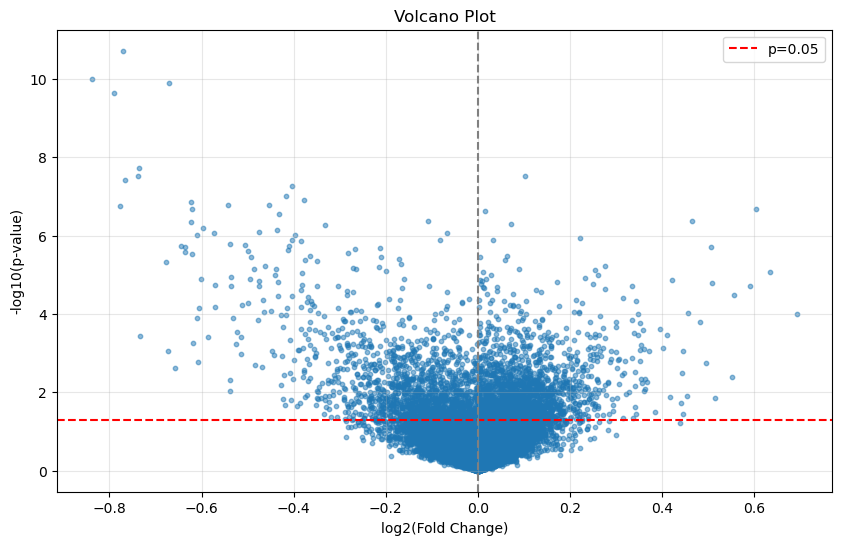

In [ ]:
import matplotlib.pyplot as plt

neg_log_p = -np.log10(results_df['p_value'])

plt.figure(figsize=(10, 6))
plt.scatter(fc_data, neg_log_p, alpha=0.5, s=10)
plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot')
plt.axhline(y=-np.log10(0.05), color='r', linestyle='--', label='p=0.05')
plt.axvline(x=0, color='gray', linestyle='--')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

c) Färben Sie die Punkte abhängig davon ein, ob sie nach der Benjamini-Hochberg-
Korrektur signifikant sind und wenn sie signifikant sind, ob die Gene in Krebspatienten
hoch- oder herunterreguliert sind (vergleiche Volcanoplot in VL).

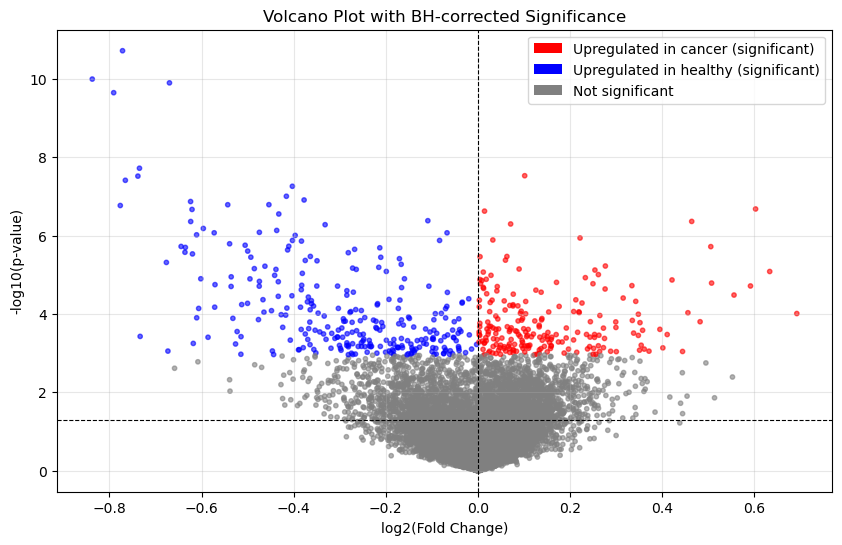

In [101]:
import matplotlib.pyplot as plt

fc_array = np.array(fc_data)
neg_log_p = -np.log10(results_df['p_value'])

significance_map = dict(zip(corrected_results['Gene'], corrected_results['significant']))
significance = results_df['Gene'].map(significance_map).values

colors = []
for i in range(len(results_df)):
    if significance[i]:
        if fc_array[i] > 0:
            colors.append('red')
        else:
            colors.append('blue')
    else:
        colors.append('gray')  # Not significant

plt.figure(figsize=(10, 6))
plt.scatter(fc_array, neg_log_p, c=colors, alpha=0.6, s=10)
plt.xlabel('log2(Fold Change)')
plt.ylabel('-log10(p-value)')
plt.title('Volcano Plot with BH-corrected Significance')
plt.axhline(y=-np.log10(0.05), color='black', linestyle='--', linewidth=0.8, label='p=0.05')
plt.axvline(x=0, color='black', linestyle='--', linewidth=0.8)

from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='red', label='Upregulated in cancer (significant)'),
    Patch(facecolor='blue', label='Upregulated in healthy (significant)'),
    Patch(facecolor='gray', label='Not significant')
]
plt.legend(handles=legend_elements)
plt.grid(True, alpha=0.3)
plt.show()